# Activity: Sampling and Training a Restricted Boltzmann Machine

In this activity, we will explore the feedforward and feedback passes of a restricted Boltzmann machine (RBM) and train it using the contrastive divergence algorithm on handwritten digit images.

__Why are we looking at this?__ The [restricted Boltzmann machine](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) overcomes the computational limitations of the general Boltzmann machine by restricting connections to form a bipartite graph between visible and hidden layers. This restriction enables efficient training using the contrastive divergence algorithm, making RBMs practical for real-world applications such as dimensionality reduction and feature learning.

> __Learning Objectives__
>
> By the end of this lab, you should be able to:
> * __Implement RBM sampling:__ Execute feedforward and feedback passes through an RBM to generate visible and hidden state configurations from input data.
> * __Train using contrastive divergence:__ Apply the CD algorithm to learn weights $\mathbf{W}$ and biases $\mathbf{a}$, $\mathbf{b}$ that capture the distribution of training images.
> * __Evaluate reconstruction quality:__ Compare the RBM's reconstructed outputs before and after training to assess learning progress.

Let's get started!
___

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants.


> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
Set some constants that we will use later. Please look at the comments in the code for more details on each constant's permissible values, units, etc.

In [5]:
number_of_images_to_explore = 200; # how many images do we want to play with?
number_of_rows = 16;
number_of_cols = 16;
number_of_pixels = number_of_rows*number_of_cols;
number_of_visible_nodes = number_of_pixels;
number_of_hidden_nodes = 4*number_of_pixels;
β = 10.0; # system (inverse) temperature 
number_of_internal_steps = 100; # how many steps do we take in the feedforward + feedback passes?
η = 0.01; # learning rate

### Implementation
The notebook uses functions for Boltzmann machine operations:

> `decode(s; number_of_rows, number_of_columns)`: Converts a flattened state vector $\mathbf{s}$ back to an $n \times n$ image matrix. This local function (defined below) reshapes the vector, transposes it to match row-major ordering, and replaces $-1$ values with $0$ for grayscale display.

In [7]:
function decode(s::Vector{Int64}; number_of_rows::Int=28, number_of_columns::Int = 28)::Array{Int64,2}

    # reconstructed image -
    X = reshape(s, number_of_rows, number_of_columns) |> X -> transpose(X) |> Matrix;
    X̂ = replace(X, -1 => 0);
    
    # return -
    return X̂
end

decode (generic function with 1 method)

___

## Task 1: Load and Explore the Data
In this task, we'll load [the USPS handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database#USPS_database) that our restricted Boltzmann machine will model. These are `16` $\times$ `16` grayscale images of handwritten numbers.

__Load the data__. Let's load [the USPS dataset by calling the `MyUSPSHandwrittenDigitImageDataset()` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyUSPSHandwrittenDigitImageDataset), transform the data to the `{-1,1}` scale, and then return this scaled data to the caller in the `X::Array{Int,2}` array, where the images are encoded in the columns of the array.

> __What is in the `X` array?__ Each column of the `X::Array{Int,2}` array holds one of the `7291` handwritten images. Each row is a pixel value; a total of `256` pixels per image. We also return the `raw_data_dictionary::Dict{Int64, Vector{Float64}}` dictionary that holds the raw (untransformed) data vectors for each image.

> __What's in the labels array?__ The `labels::Vector{Int}` array holds the actual digit (0-9) corresponding to each image in the `X` array.

In [ ]:
X, labels = let

    # load the dataset
    results = MyUSPSHandwrittenDigitImageDataset(); 
    records = results.records;
    labels = results.labels;
    number_of_records = length(labels);

    # get the number of records -
    X = Array{Int,2}(undef, number_of_pixels, number_of_records);

    for i ∈ 1:number_of_records
        record = records[i];
        for k ∈ 1:number_of_pixels
            if (record[k] ≤ 0.0)
                X[k,i] = -1;
            else
                X[k,i] = 1;
            end
        end
    end

    X[:,1:number_of_images_to_explore], labels[1:number_of_images_to_explore]
end;

Let's check the data:

Selected index = 27 has label = 3


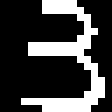

In [12]:
let

    # initialize -
    number_of_records = length(labels);
    i = rand(1:number_of_records);

    println("Selected index = $(i) has label = $(labels[i])")
    X[:,i] |> s-> decode(s, number_of_rows = number_of_rows, number_of_columns = number_of_cols) |> img -> Gray.(img)
end

__Probability distribution of the data__. In the code below, we want to be able to sample the data, for example, generate mini-batches of data to estimate the model parameters. However, we cannot compute the partition function even though our data vectors are relatively small, i.e., `16^2 = 256` pixels. 

> __Approximating the data distribution__
>
> Let's compute the probability of observing a pattern in the _data that we do have_, and use this to approximate $P(\mathbf{x})_{\text{data}}$. We compare each pattern to every other by computing a _dissimilarity score_. If the dissimilarity is below a threshold, the patterns are assumed to be similar. We compute an approximate probability of seeing _similar_ patterns [using the `softmax(...)` method](src/Compute.jl) and use this to initialize [a `Categorical` distribution exported by the `Distributions.jl` package](https://juliastats.org/Distributions.jl/latest/univariate/#Distributions.Categorical).

We save the categorical distribution in the `data_distribution::Categorical{Float64, Vector{Float64}}` variable.


In [14]:
(data_distribution,p) = let

    # initialize -
    number_of_samples = size(X, 2); # how many turns do we have
    θ = Array{Float64,1}(undef, number_of_samples);

    for i ∈ 1:number_of_samples
        sᵢ = X[:,i]; # get the ith pixel pattern

        counter = 0;
        for j ∈ 1:number_of_samples
            sⱼ = X[:,j]; # get the jth pixel pattern

            # compute the difference -
            d = (1/(4*number_of_pixels))*sum((sᵢ .- sⱼ).^2);            
            if (d ≤ 0.20)
                counter += 1;
            end
        end
        θ[i] = counter/number_of_samples
    end

    # initialize categorical distribution w/p -
    p = softmax(θ);
    data_distribution = Categorical(p);

    data_distribution,p    
end;

___

## Task 2: Feedforward and Feedback Passes
In this task, let's assume some random values for the parameters $\mathbf{W}$, $\mathbf{a}$, and $\mathbf{b}$ and see what happens when we do a combined _feedforward_ and _feedback_ pass through the restricted Boltzmann machine. First, let's build a model. We'll create an instance of [the `MyRestrictedBoltzmannMachineModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/boltzmann/#VLDataScienceMachineLearningPackage.MyRestrictedBoltzmannMachineModel) with random values for the $\mathbf{W}$, $\mathbf{a}$, and $\mathbf{b}$ parameters.

> The [`randn(...)` method](https://docs.julialang.org/en/v1/stdlib/Random/#Base.randn) generates normally distributed random numbers with mean `0` and standard deviation `1`. 

In [17]:
model = let 
    
    # initialize some random weights and biases
    W = 2*randn(number_of_visible_nodes, number_of_hidden_nodes);
    a = randn(number_of_visible_nodes)
    b = randn(number_of_hidden_nodes);

    # next, build the model -
    model = build(MyRestrictedBoltzmannMachineModel, (
        W = W,
        a = a,
        b = b,
    ));

    # return -
    model;
end;

__Sample__. We've implemented the restricted Boltzmann machine's feedforward and feedback passes in [the `sample(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/boltzmann/#VLDataScienceMachineLearningPackage.sample-Tuple{MyRestrictedBoltzmannMachineModel,%20Vector{Int64}}).

> __What is going on?__ Break up into groups and describe to each other what is going on in the feedforward and feedback passes of the RBM. Check out [the `sample(...)` method documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/boltzmann/) for implementation details.

The `sample(...)` method returns a tuple `(v, h)` containing the visible layer states $\mathbf{v}$ and hidden layer states $\mathbf{h}$ recorded at each of the `T` internal steps.

In [19]:
(vₒ,v, h) = let

    # draw a random index from the data distribution
    i = rand(data_distribution);
    
    vₒ = X[:,i]; # initial visible layer values
    (v,h) = VLDataScienceMachineLearningPackage.sample(model, vₒ, T = number_of_internal_steps, β = β);

    (vₒ,v,h)
end;

In [20]:
h

1024×100 Matrix{Int64}:
  1   1   1   1   1   1   1   1   1  …   1   1   1   1   1   1   1   1   1
  1   1   1  -1  -1  -1   1   1   1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
  1   1   1   1   1   1   1   1  -1  …  -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1  …   1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 

__What are we giving the RBM__? We specify the initial condition for the _visible layer_ by drawing a sample $\mathbf{v}_{\circ}\sim{P}(\mathbf{x})_{\text{data}}$ using the data distribution $P(\mathbf{x})_{\text{data}}$ that we estimated in `Task 1`. What is that sample?

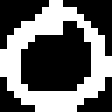

In [22]:
decode(vₒ, number_of_rows = number_of_rows, number_of_columns = number_of_cols) |> img -> Gray.(img)

__After a single pass, what do we see__? We gave $\mathbf{v}_{\circ}$, and then did `number_of_internal_steps::Int` number of internal steps, i.e., $n$-feedforward steps which generated $\mathbf{h}_{1},\dots,\mathbf{h}_{n}$. From that sequence, we grab the last value, and then we generate $\mathbf{v}_{1},\dots,\mathbf{v}_{n}$ feedback steps _starting_ from $\mathbf{h}_{n}$.

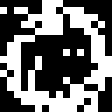

Turn index = 100


In [24]:
let
    do_I_want_to_see_a_movie = true; # set this flag to watch the frames
    should_clear_output = isdefined(Main, :IJulia) && IJulia.inited
    if (do_I_want_to_see_a_movie == true)
        for i ∈ 1:number_of_internal_steps
            img = decode(v[:,i], number_of_rows = number_of_rows, number_of_columns = number_of_cols);
            display(Gray.(img))
            println("Turn index = $(i)")
            if (should_clear_output == true)
                IJulia.clear_output(true) # may not work in VSCode?
            end
            sleep(0.1) # add some delay
        end
    end
end

__What does the hidden layer look like?__ A strange (and frustrating) thing about deep learning and neural networks in general is the lack of interpretability. Let's visualize how the _hidden_ layer is changing during the $n$ feedforward steps.

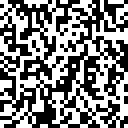

Turn index = 100


In [26]:
let

    # initialize -
    number_of_rows = sqrt(number_of_hidden_nodes) |> x-> round(Int,x)
    number_of_cols = sqrt(number_of_hidden_nodes) |> x-> round(Int,x)
    should_clear_output = isdefined(Main, :IJulia) && IJulia.inited

    do_I_want_to_see_a_movie = true; # set this flag to watch the frames
    if (do_I_want_to_see_a_movie == true)
        for i ∈ 1:number_of_internal_steps
            img = decode(h[:,i], number_of_rows = number_of_rows, number_of_columns = number_of_cols);
            display(Gray.(img))
            println("Turn index = $(i)")
            if (should_clear_output == true)
                IJulia.clear_output(true) # may not work in VSCode?
            end
            sleep(0.1) # add some delay
        end
    end
end

___

## Task 3: Training with Contrastive Divergence
In this task, let's do a few training steps and see how this changes the behavior of the restricted Boltzmann machine. 

> __Contrastive Divergence (CD)__
>
> The training method for the RBM is known as contrastive divergence. The CD algorithm approximates the gradient of the log-likelihood by running a limited number of Gibbs sampling steps rather than waiting for equilibrium. See this [description of the CD algorithm](https://ml-lectures.org/docs/unsupervised_learning/ml_unsupervised-1.html#training-an-rbm) for more details. We've implemented the CD algorithm in [the `learn(...)` method](src/Compute.jl). 
> * The [`learn(...)` method](src/Compute.jl) takes a `model::MyRestrictedBoltzmannMachineModel` instance, the image dataset `X::Array{Int,2}` array, our approximate value for $P(\mathbf{x})_{\text{data}}$, the system (inverse) temperature `β::Float64`, the learning rate `η::Float64` and some other control parameters, e.g., `maxnumberofiterations::Int` which is the maximum number of iterations we want the training to go for.

This method returns a new `MyRestrictedBoltzmannMachineModel` with the updated parameters.

In [29]:
newmodel = let

    # initialize -
    do_I_want_to_train_the_model = true;
    newmodel = nothing;
    localmaxnumberofiterations = 100;
    localbatchsize = 50;
    verboseflag = true;

    if (do_I_want_to_train_the_model == true)
        newmodel = learn(model,X,data_distribution, maxnumberofiterations = localmaxnumberofiterations,
            T = number_of_internal_steps, β = β, η = η, verbose = verboseflag, 
                batchsize = localbatchsize); # do a few training steps, and let's see what is going on?
    else
        newmodel = model; # skip the training, return the old model 
    end

    # return -
    newmodel;
end;

Iteration: 1, max parameter change: 0.06515172905394252
Iteration: 2, max parameter change: 0.03822840758642581
Iteration: 3, max parameter change: 0.03612747142154285
Iteration: 4, max parameter change: 0.033435730693706235
Iteration: 5, max parameter change: 0.030268779149972308
Iteration: 6, max parameter change: 0.030465595658859673
Iteration: 7, max parameter change: 0.02658700285161801
Iteration: 8, max parameter change: 0.026718498183565465
Iteration: 9, max parameter change: 0.02609247979629281
Iteration: 10, max parameter change: 0.022684293023883133
Iteration: 11, max parameter change: 0.02178739245559118
Iteration: 12, max parameter change: 0.022929900304266455
Iteration: 13, max parameter change: 0.020917450997406117
Iteration: 14, max parameter change: 0.01981637695511389
Iteration: 15, max parameter change: 0.019329762492616902
Iteration: 16, max parameter change: 0.018333772860500624
Iteration: 17, max parameter change: 0.018149767974921526
Iteration: 18, max parameter c

__After a single pass of the trained model, what do we see__? We gave $\bar{\mathbf{v}}_{\circ}$, and then did `number_of_internal_steps::Int` number of internal steps, i.e., $n$-feedforward steps which generated $\bar{\mathbf{h}}_{1},\dots,\bar{\mathbf{h}}_{n}$, and then we generated $\bar{\mathbf{v}}_{1},\dots,\bar{\mathbf{v}}_{n}$ feedback steps _starting_ from $\bar{\mathbf{h}}_{n}$.

In [144]:
vₒ, v̄ₒ, v̄, h̄ = let

    # draw a random index from the data distribution
    i = rand(data_distribution);
    vₒ = copy(X[:,i]); # initial visible layer values
    v̄ₒ = copy(vₒ); 
    local_number_of_internal_steps = 5;

    # let's make this a little harder -
    for j ∈ eachindex(vₒ)
        if (rand() ≤ 0.2)
            v̄ₒ[j] = -1;
        end
    end

    # run the simulation -
    (v,h) = VLDataScienceMachineLearningPackage.sample(newmodel, vₒ, 
        T = local_number_of_internal_steps, β = 0.1*β);

    # return -
    vₒ, v̄ₒ, v, h
end;

__What are we giving the updated RBM__? We specify the initial condition for the _visible layer_ by drawing a sample $\mathbf{v}_{\circ}\sim{P}(\mathbf{x})_{\text{data}}$ using the data distribution $P(\mathbf{x})_{\text{data}}$ that we estimated in `Task 1`. What is that sample?

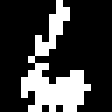

In [146]:
decode(v̄ₒ, number_of_rows = number_of_rows, number_of_columns = number_of_cols) |> img -> Gray.(img)

__What is the original (uncorrupted) image?__ This is the true image from the dataset before we randomly corrupted some pixels to test the network's reconstruction ability.

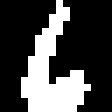

In [148]:
decode(vₒ, number_of_rows = number_of_rows, number_of_columns = number_of_cols) |> img -> Gray.(img)

So what does the model return in $\bar{\mathbf{v}}$?

In [150]:
v̄

256×5 Matrix{Int64}:
 -1  -1  -1   1   1
 -1   1  -1  -1   1
 -1   1  -1  -1   1
 -1  -1  -1  -1  -1
 -1  -1   1  -1   1
 -1   1   1   1   1
 -1  -1  -1  -1   1
 -1  -1   1  -1  -1
  1   1   1   1   1
 -1   1   1  -1  -1
 -1  -1  -1  -1  -1
 -1  -1   1   1   1
 -1  -1   1   1  -1
  ⋮              
  1   1   1   1   1
  1   1  -1  -1  -1
  1   1   1  -1   1
  1   1   1   1   1
  1   1  -1  -1  -1
  1   1   1   1  -1
  1   1  -1  -1  -1
 -1   1   1  -1  -1
 -1  -1  -1  -1  -1
 -1  -1  -1   1   1
 -1  -1  -1  -1  -1
 -1  -1  -1  -1   1

What does the network give back?

Selected index 5


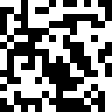

In [152]:
let

    # initialize -
    local_number_of_internal_steps = size(v̄,2);
    i = local_number_of_internal_steps;
    println("Selected index $(i)");
    decode(v̄[:,i], number_of_rows = number_of_rows, number_of_columns = number_of_cols) |> img -> Gray.(img)
end

## Summary
This lab explored the sampling and training of a restricted Boltzmann machine on handwritten digit images using contrastive divergence.

> __Key Takeaways__
>
> * **Feedforward and feedback passes:** An RBM generates hidden states from visible inputs (feedforward) and reconstructs visible states from hidden activations (feedback) using conditional probabilities derived from the energy function.
> * **Contrastive divergence training:** The CD algorithm updates weights and biases by comparing correlations between data-driven activations and model reconstructions, avoiding the need to compute the intractable partition function.
> * **Reconstruction improvement:** After training, the RBM produces reconstructions that better match the input data distribution, demonstrating that the network has learned the underlying structure of the images.

The trained RBM can be used for tasks such as dimensionality reduction, feature learning, and generative modeling.
___